In [255]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn import metrics

import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio

from sklearn.decomposition import PCA



### Read in the dataset

In [449]:
df= pd.read_csv(r"C:\Users\ddrye\OneDrive\Desktop\SVI_CO2_2015-2018.csv")

In [504]:
print(df.shape)
pd.set_option('display.max_columns', None)
display(df.sort_values(['geoid','year']).head(25))

(11571574, 25)


Unnamed: 0  geoid county_name state_name_x  year  readings_count  \
0            0   1001     Autauga      Alabama  2015              43   
1            1   1001     Autauga      Alabama  2016             268   
2            1   1001     Autauga      Alabama  2016             268   
3            1   1001     Autauga      Alabama  2016             268   
4            1   1001     Autauga      Alabama  2016             268   
5            1   1001     Autauga      Alabama  2016             268   
6            1   1001     Autauga      Alabama  2016             268   
7            1   1001     Autauga      Alabama  2016             268   
8            1   1001     Autauga      Alabama  2016             268   
9            1   1001     Autauga      Alabama  2016             268   
10           1   1001     Autauga      Alabama  2016             268   
11           1   1001     Autauga      Alabama  2016             268   
12           1   1001     Autauga      Alabama  2016             268   
13           1   1001     Autauga      Alabama  2016             268   
14           1   1001     Autauga      Alabama  2016             268   
15           1   1001     Autauga      Alabama  2016             268   
16           1   1001     Autauga      Alabama  2016             268   
17           1   1001     Autauga      Alabama  2016             268   
18           1   1001     Autauga      Alabama  2016             268   
19           1   1001     Autauga      Alabama  2016             268   
20           1   1001     Autauga      Alabama  2016             268   
21           1   1001     Autauga      Alabama  2016             268   
22           1   1001     Autauga      Alabama  2016             268   
23           1   1001     Autauga      Alabama  2016             268   
24           1   1001     Autauga      Alabama  2016             268   

    stddev_xco2   avg_xco2  co2_delta  co2_cum_delta  co2_pct_change  \
0      0.945703  396.25750        NaN            NaN             NaN   
1      1.087421  403.38025   7.122742       7.122742        1.017975   
2      1.087421  403.38025   7.122742       7.122742        1.017975   
3      1.087421  403.38025   7.122742       7.122742        1.017975   
4      1.087421  403.38025   7.122742       7.122742        1.017975   
5      1.087421  403.38025   7.122742       7.122742        1.017975   
6      1.087421  403.38025   7.122742       7.122742        1.017975   
7      1.087421  403.38025   7.122742       7.122742        1.017975   
8      1.087421  403.38025   7.122742       7.122742        1.017975   
9      1.087421  403.38025   7.122742       7.122742        1.017975   
10     1.087421  403.38025   7.122742       7.122742        1.017975   
11     1.087421  403.38025   7.122742       7.122742        1.017975   
12     1.087421  403.38025   7.122742       7.122742        1.017975   
13     1.087421  403.38025   7.122742       7.122742        1.017975   
14     1.087421  403.38025   7.122742       7.122742        1.017975   
15     1.087421  403.38025   7.122742       7.122742        1.017975   
16     1.087421  403.38025   7.122742       7.122742        1.017975   
17     1.087421  403.38025   7.122742       7.122742        1.017975   
18     1.087421  403.38025   7.122742       7.122742        1.017975   
19     1.087421  403.38025   7.122742       7.122742        1.017975   
20     1.087421  403.38025   7.122742       7.122742        1.017975   
21     1.087421  403.38025   7.122742       7.122742        1.017975   
22     1.087421  403.38025   7.122742       7.122742        1.017975   
23     1.087421  403.38025   7.122742       7.122742        1.017975   
24     1.087421  403.38025   7.122742       7.122742        1.017975   

    household  Longitude  Latitude  housing  minority  overall  socioeconomic  \
0         NaN        NaN       NaN      NaN       NaN      NaN            NaN   
1      0.9305 -86.708334      32.7   0.5130    0.2153   0.5965         0.5599   
2      0.9305 -

Seems to be something going on where we have many repeats from any given county. I think we left-joined the OCO2 data TO the SEDAC data, so is each repeat an individual census reading from within that county? - This doesn't seem the case, Autauga AL has 12 census tracts and we are seeing more than that above

There are some rows that only differ in their lat and lon values and others that differ in the socioecon values (see rows 1 and 11 for example); all within the same year. Whats going on here?

I could get rid of the lat and lon data and remove duplicates. Then average the remaining values for the different socioecon values within each county. Or should I just average all rows for a given county? I'm going to try the latter


In [559]:
print("total rows of sedac and co2 dataframe",len(df))

#focussing on variables of interest and discarding the lat lon values that are giving us those duplicates
df1=df.groupby(['year','geoid','state_name_y','state_name_x','name','county_name'],as_index=False)[['household','housing','minority','overall','socioeconomic','co2_pct_change','avg_xco2','readings_count','co2_delta',
                                                                                                    'co2_cum_delta']].mean()


print("total rows without weird duplicates",len(df1))

#what about nans
display(df1[df1.isna().any(axis=1)].head())

#dropping the na values
df_filter=df1.dropna()
print('total rows without nans',len(df_filter))

#difference
print("difference between orig df and processed:",len(df)-len(df_filter))

#lets filter for counties with 100 or more xco2 readings
df_filter = df_filter[df_filter.readings_count >= 100]

#and filter on a certain year
#df_filter=df_filter[df_filter['year']==2016]

display(df_filter.head())
print("shape for selected year",df_filter.shape)

total rows of sedac and co2 dataframe 11571574
total rows without weird duplicates 5543


year  geoid state_name_y state_name_x      name county_name  household  \
8   2016   1017      Alabama      Alabama  Chambers    Chambers   0.732997   
9   2016   1019      Alabama      Alabama  Cherokee    Cherokee   0.783174   
14  2016   1029      Alabama      Alabama  Cleburne    Cleburne   0.723914   
23  2016   1047      Alabama      Alabama    Dallas      Dallas   0.865865   
39  2016   1079      Alabama      Alabama  Lawrence    Lawrence   0.706618   

     housing  minority   overall  socioeconomic  co2_pct_change   avg_xco2  \
8   0.754439  0.329058  0.729527       0.733419             NaN  404.48993   
9   0.257692  0.099583  0.434252       0.621994             NaN  402.18994   
14  0.504338  0.181570  0.588564       0.727014             NaN  403.85922   
23  0.646244  0.410111  0.807963       0.847304             NaN  403.36807   
39  0.350659  0.264394  0.556624       0.724683             NaN  401.63230   

    readings_count  co2_delta  co2_cum_delta  
8             86.0        NaN            NaN  
9             74.0        NaN            NaN  
14            51.0        NaN            NaN  
23           281.0        NaN            NaN  
39             2.0        NaN            NaN

total rows without nans 5251
difference between orig df and processed: 11566323


year  geoid state_name_y state_name_x     name county_name  household  \
0  2016   1001      Alabama      Alabama  Autauga     Autauga   0.763452   
1  2016   1003      Alabama      Alabama  Baldwin     Baldwin   0.558066   
2  2016   1005      Alabama      Alabama  Barbour     Barbour   0.743810   
3  2016   1007      Alabama      Alabama     Bibb        Bibb   0.546431   
4  2016   1009      Alabama      Alabama   Blount      Blount   0.720242   

    housing  minority   overall  socioeconomic  co2_pct_change   avg_xco2  \
0  0.564878  0.291090  0.576258       0.554267        1.017975  403.38025   
1  0.480118  0.220866  0.456817       0.546375        1.004117  402.85437   
2  0.661855  0.640937  0.843168       0.869758        1.011410  404.57000   
3  0.481622  0.316578  0.530467       0.641191        1.001848  403.44320   
4  0.526141  0.373937  0.615521       0.665398        1.005051  403.63913   

   readings_count  co2_delta  co2_cum_delta  
0           268.0   7.122742       7.122742  
1           739.0   1.651855       1.651855  
2           116.0   4.564026       4.564026  
3           171.0   0.744019       0.744019  
4           345.0   2.028381       2.028381

shape for selected year (3781, 16)


 Taking a look at rows with missing values. These look to be connected to the SEDAC data because we are getting the socioecon values, but not co2 values. It seems that these SEDAC values could not be connected to a geoid and so could not be related to the oco2 data (?). Dropping these columns with na values cuts the number of rows of data for 2016 roughly in half
 
 This seems to be unique to the 2016 data.. Does not appear to be an issue with the 2018 data

Google says there are 3,142 counties in the US. We are not hittin all of those

In [560]:
df_filter['name'].nunique()

1479

### Some Plots just for the heck of it

<Axes: xlabel='state_name_x', ylabel='overall'>

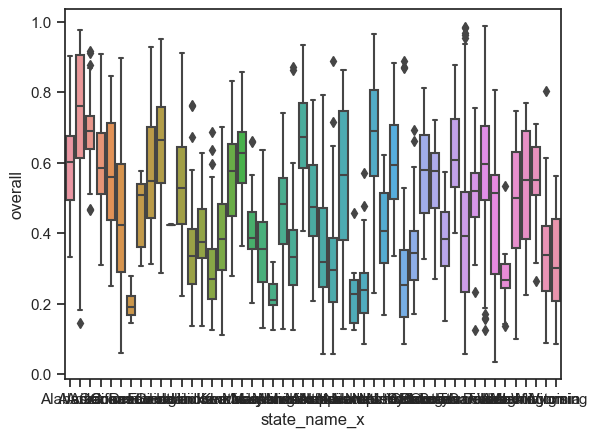

In [554]:
sns.boxplot(x = df_filter['state_name_x'],
            y = df_filter['overall'])

[(390.0, 405.0)]

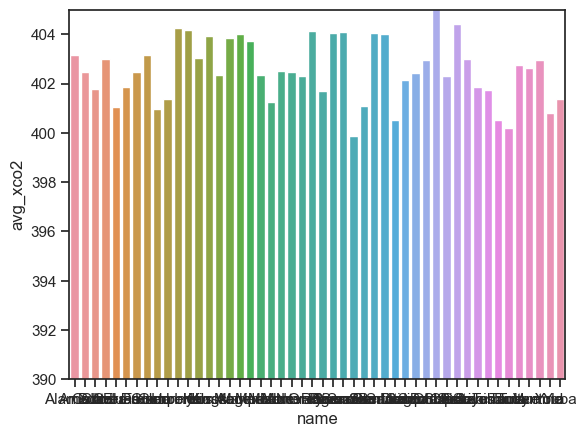

In [508]:
california=df_filter[df_filter['state_name_x']=='California']
ax=sns.barplot(data=california, x="name", y="avg_xco2")
ax.set(ylim=(390, 405))

array([[<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'geoid'}>,
        <Axes: title={'center': 'household'}>],
       [<Axes: title={'center': 'housing'}>,
        <Axes: title={'center': 'minority'}>,
        <Axes: title={'center': 'overall'}>],
       [<Axes: title={'center': 'socioeconomic'}>,
        <Axes: title={'center': 'co2_pct_change'}>,
        <Axes: title={'center': 'avg_xco2'}>],
       [<Axes: title={'center': 'readings_count'}>,
        <Axes: title={'center': 'co2_delta'}>,
        <Axes: title={'center': 'co2_cum_delta'}>]], dtype=object)

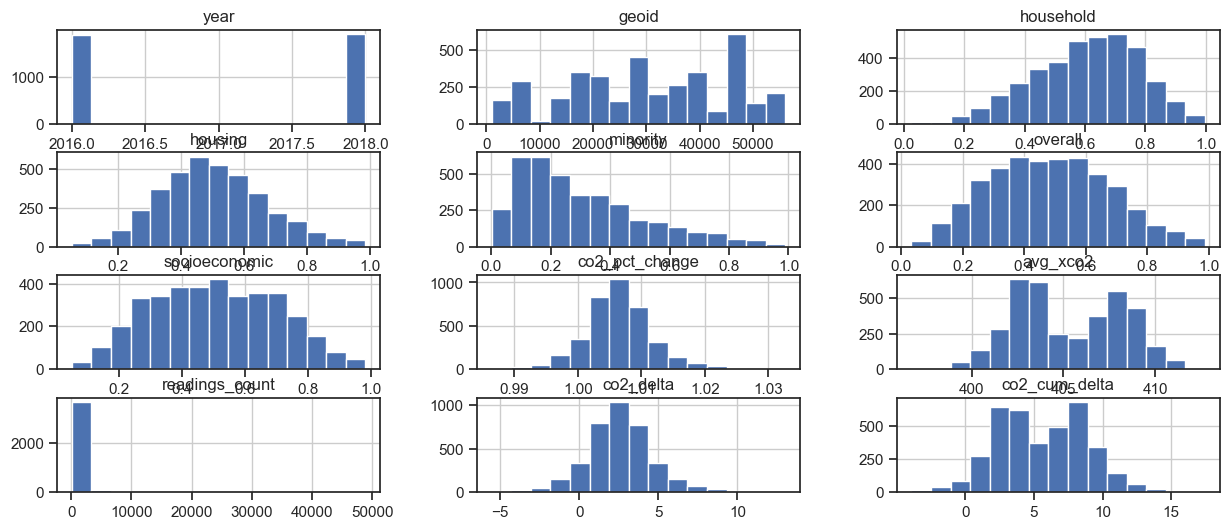

In [561]:
#df_filter=df_filter[['household','housing','minority','socioeconomic','avg_xco2']]
df_filter.hist(bins=15, figsize=(15, 6))

## Pairplots

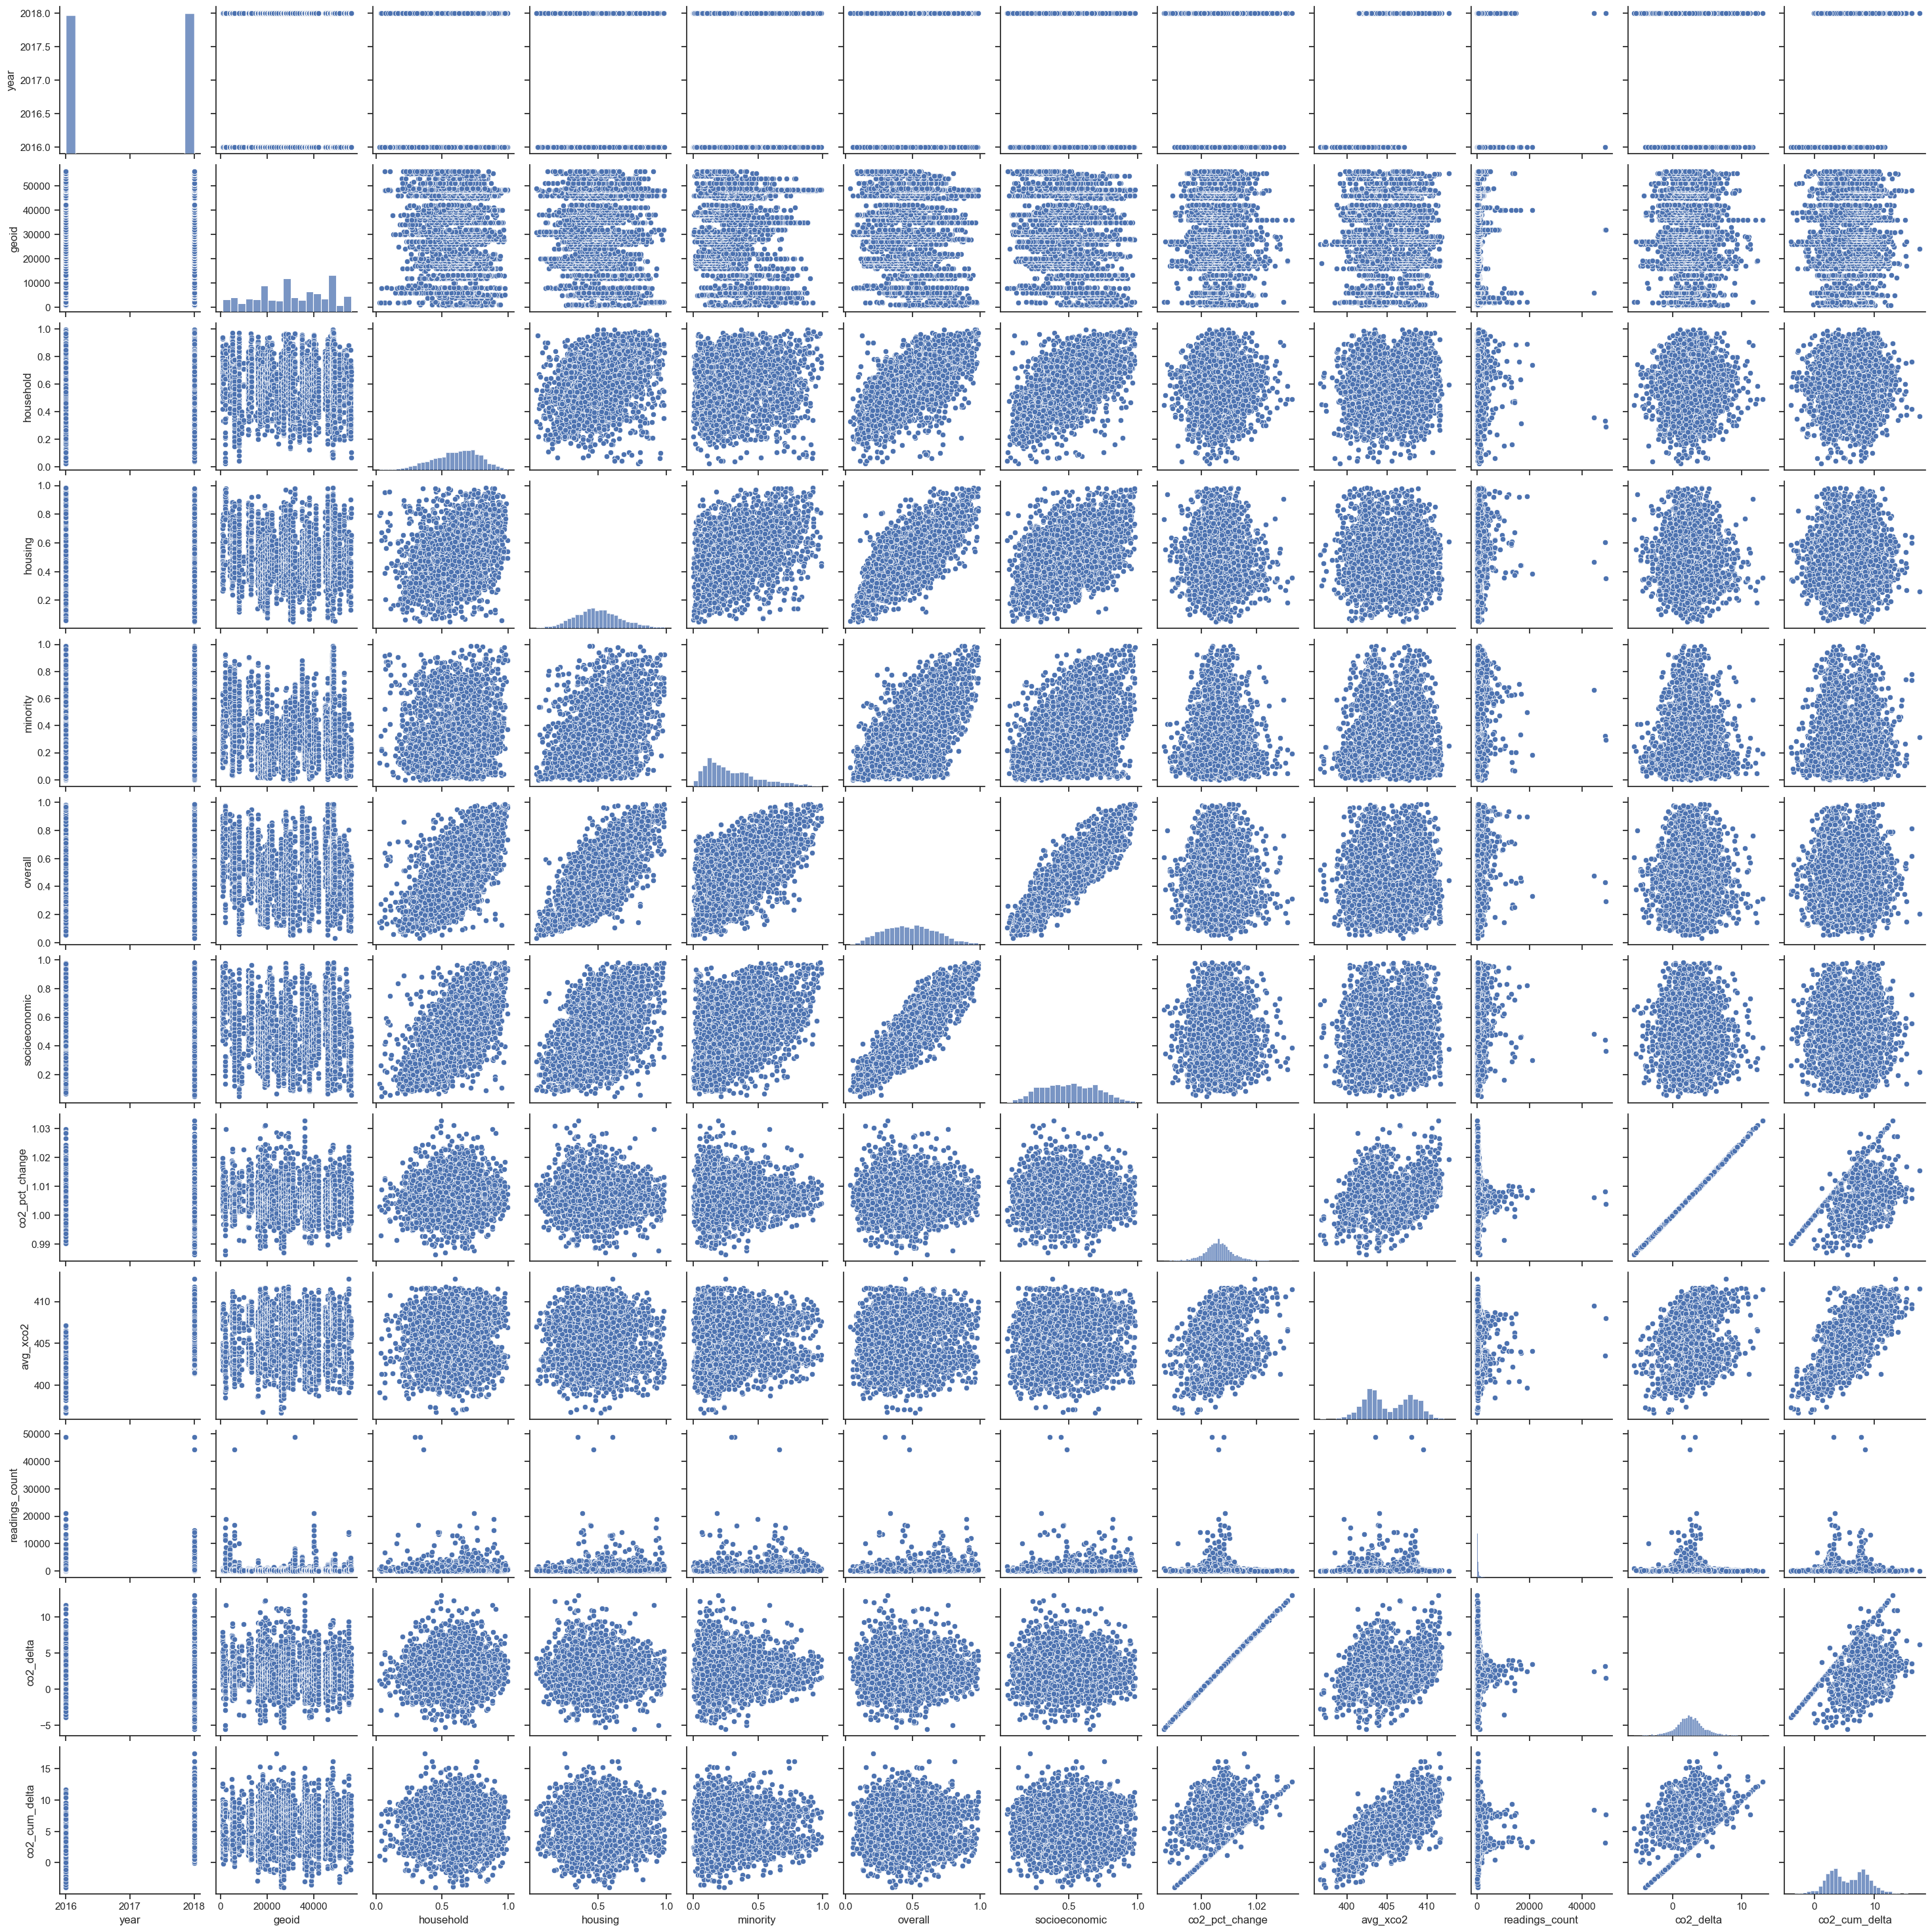

In [562]:
sns.set(style="ticks")
sns.pairplot(data= df_filter)

## scaling the data

In [533]:
print(df_filter.head())
df_filter=df_filter[['household','housing','minority','socioeconomic','avg_xco2']]

   year  geoid state_name_y state_name_x     name county_name  household  \
0  2016   1001      Alabama      Alabama  Autauga     Autauga   0.763452   
1  2016   1003      Alabama      Alabama  Baldwin     Baldwin   0.558066   
2  2016   1005      Alabama      Alabama  Barbour     Barbour   0.743810   
3  2016   1007      Alabama      Alabama     Bibb        Bibb   0.546431   
4  2016   1009      Alabama      Alabama   Blount      Blount   0.720242   

    housing  minority   overall  socioeconomic  co2_delta  co2_pct_change  \
0  0.564878  0.291090  0.576258       0.554267   7.122742        1.017975   
1  0.480118  0.220866  0.456817       0.546375   1.651855        1.004117   
2  0.661855  0.640937  0.843168       0.869758   4.564026        1.011410   
3  0.481622  0.316578  0.530467       0.641191   0.744019        1.001848   
4  0.526141  0.373937  0.615521       0.665398   2.028381        1.005051   

    avg_xco2  readings_count  
0  403.38025           268.0  
1  402.85437      

In [534]:
columns = df_filter.columns

#Initialize scaler
scaler = StandardScaler()

#scale the data
clus_df = pd.DataFrame(scaler.fit_transform(df_filter))

#Rename plot_df's columns
clus_df.columns = columns

## without pca

In [535]:
# Using KNN to find optimal epsilon

min_samples = int(len(clus_df.columns))

neigh = NearestNeighbors(n_neighbors=min_samples)
nbrs = neigh.fit(clus_df)
distances, indices = nbrs.kneighbors(clus_df)

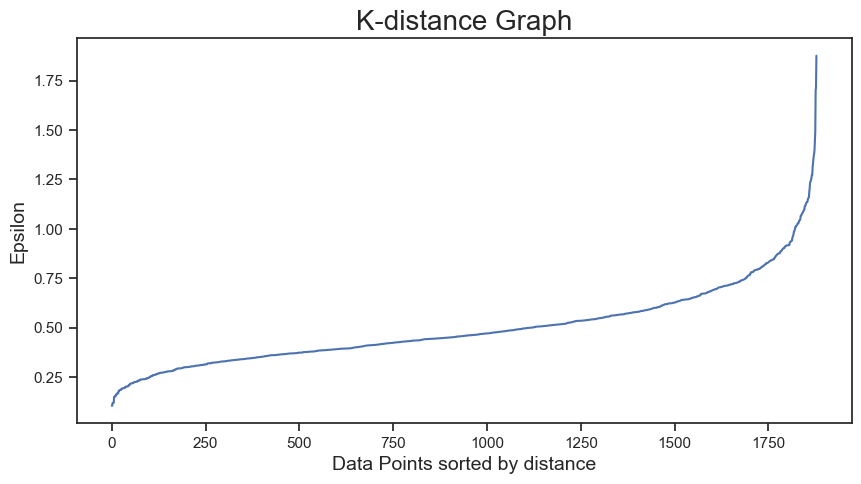

In [536]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,5))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [540]:
#run DBSCAN
eps = .75

dbscan = DBSCAN(eps = eps, min_samples = min_samples)
dbscan.fit(clus_df)

DBSCAN(eps=0.75)

In [538]:
clus_df['Cluster']=dbscan.labels_
clus_df['Cluster'].value_counts()

Cluster
 0    1494
-1     348
 2      11
 1       7
 6       7
 4       4
 5       4
 3       4
Name: count, dtype: int64

In [541]:
labels = dbscan.labels_
# measure the performance of dbscan algo
# Identifying which points make up our “core points”
core_samples = np.zeros_like(labels, dtype=bool)
core_samples[dbscan.core_sample_indices_] = True
print(core_samples)

#Calculating "the number of clusters"
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters_)

#Computing "the Silhouette Score"
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(clus_df, labels))

[ True  True False ...  True  True  True]
4
Silhouette Coefficient: 0.151


## PCA

### Scaling the data

In [542]:
columns = df_filter.columns

#Initialize scaler
scaler = StandardScaler()

#scale the data
clus_df = pd.DataFrame(scaler.fit_transform(df_filter))

#Rename plot_df's columns
clus_df.columns = columns

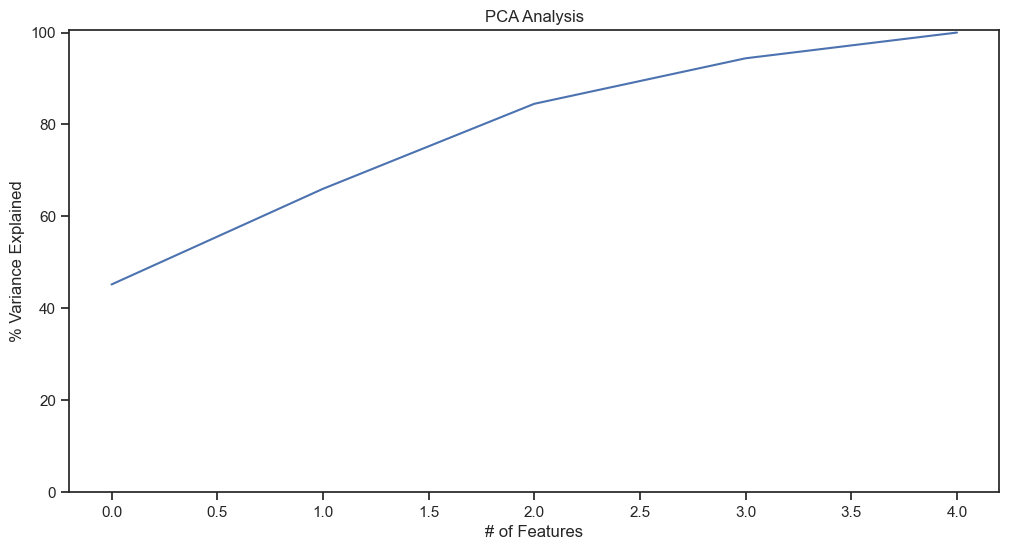

In [543]:
pca = PCA(n_components=len(clus_df.columns))
pca.fit(clus_df)
variance = pca.explained_variance_ratio_ 
var=np.cumsum(np.round(variance, 3)*100)
plt.figure(figsize=(12,6))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(0,100.5)
plt.plot(var)

In [544]:
pca = PCA(n_components=3)
pca.fit(clus_df)
pca_scale = pca.transform(clus_df)
pca_df = pd.DataFrame(pca_scale, columns=['pc1', 'pc2', 'pc3'])
print(pca.explained_variance_ratio_)

[0.45203002 0.20782099 0.18459877]


In [545]:
Scene = dict(xaxis = dict(title  = 'PC1'),yaxis = dict(title  = 'PC2'),zaxis = dict(title  = 'PC3'))
trace = go.Scatter3d(x=pca_df.iloc[:,0], y=pca_df.iloc[:,1], z=pca_df.iloc[:,2], mode='markers',marker=dict(colorscale='Greys', opacity=0.3, size = 10, ))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene, height = 1000,width = 1000)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

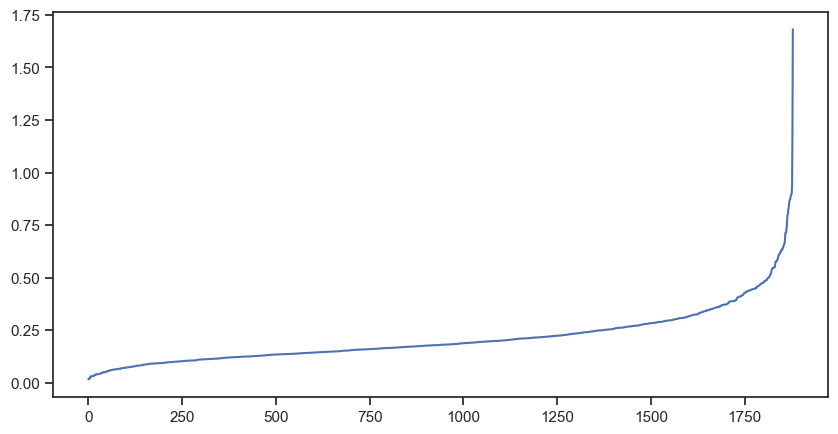

In [549]:
plt.figure(figsize=(10,5))
nn = NearestNeighbors(n_neighbors=6).fit(pca_df)
distances, idx = nn.kneighbors(pca_df)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.show()

In [550]:
db = DBSCAN(eps=0.5, min_samples=6).fit(pca_df)
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(pca_df, labels))

Estimated number of clusters: 3
Estimated number of noise points: 212
Silhouette Coefficient: -0.110


In [551]:
Scene = dict(xaxis = dict(title  = 'PC1'),yaxis = dict(title  = 'PC2'),zaxis = dict(title  = 'PC3'))
labels = db.labels_
trace = go.Scatter3d(x=pca_df.iloc[:,0], y=pca_df.iloc[:,1], z=pca_df.iloc[:,2], mode='markers',marker=dict(color = labels, colorscale='Viridis', size = 10, line = dict(color = 'gray',width = 5)))
layout = go.Layout(scene = Scene, height = 1000,width = 1000)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.update_layout(title='DBSCAN clusters (53) Derived from PCA', font=dict(size=12,))
fig.show()

In [386]:
labels = dbscan.labels_
# measure the performance of dbscan algo
# Identifying which points make up our “core points”
core_samples = np.zeros_like(labels, dtype=bool)
core_samples[dbscan.core_sample_indices_] = True
print(core_samples)

#Calculating "the number of clusters"
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters_)

#Computing "the Silhouette Score"
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(clus_df, labels))

[False  True  True ...  True False  True]
7
Silhouette Coefficient: 0.113


In [389]:
db = DBSCAN(eps=.175, min_samples=6).fit(pca_df)
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(pca_df, labels))

Estimated number of clusters: 0
Estimated number of noise points: 1361


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [388]:
Scene = dict(xaxis = dict(title  = 'PC1'),yaxis = dict(title  = 'PC2'),zaxis = dict(title  = 'PC3'))
labels = db.labels_
trace = go.Scatter3d(x=pca_df.iloc[:,0], y=pca_df.iloc[:,1], z=pca_df.iloc[:,2], mode='markers',marker=dict(color = labels, colorscale='Viridis', size = 10, line = dict(color = 'gray',width = 5)))
layout = go.Layout(scene = Scene, height = 1000,width = 1000)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.update_layout(title='DBSCAN clusters (53) Derived from PCA', font=dict(size=12,))
fig.show()